In [1]:
import pandas as pd
import random
import networkx as nx
import os

from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Table
import reportlab
import networkx as nx
import matplotlib.pyplot as plt
from reportlab.lib import colors
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

In [2]:
#генерация датасета
df_dict = {}

count_operation = 500

for i in range(count_operation):
    df_dict[i] = {'reciver' : random.randint(1, count_operation/2),
                  'sender': random.randint(1, count_operation/2),
                  'sum_oper': random.randint(1000, 1000000),
                  'suspisios_transaction': random.randint(0, 1)}

for i in range(100):
    df_dict[i] = {'reciver' : 1,
                  'sender': random.randint(1, count_operation/2),
                  'sum_oper': random.randint(1000, 1000000),
                  'suspisios_transaction': random.randint(0, 1)}

df =  pd.DataFrame().from_dict(df_dict).T

#создание графа
graph = nx.DiGraph()

for loc in range(len(df)):
    rec = df.iloc[loc].reciver
    send = df.iloc[loc].sender
    sum_o = df.iloc[loc].sum_oper
    flag = df.iloc[loc].suspisios_transaction

    graph.add_edge(rec, send, sum_oper = sum_o, suspisios_transaction=flag)
    
#вычисление метрик
df_degrees = pd.DataFrame().from_dict(nx.degree(graph)).sort_values(1, ascending=False).rename(columns={0:'node', 1:'degree'})
bet = dict([(k, round(v,2)) for k,v in nx.betweenness_centrality(graph).items()])
pagerank = dict([(k, round(v,2)) for k,v in nx.pagerank(graph).items()])
df_betwenness = pd.DataFrame().from_dict(bet, orient='index').reset_index().sort_values(0, ascending=False).rename(columns={'index':'node', 0:'betweenness'})
df_pagerank = pd.DataFrame().from_dict(pagerank, orient='index').reset_index().sort_values(0, ascending=False).rename(columns={'index':'node', 0:'pagerank'})

#Расчет цвета вершин и ребер
df['color_edge'] = df.suspisios_transaction.apply(lambda x: 'red' if x==1 else 'green')
color_node = df_degrees['degree'].apply(lambda x: 'red' if x>6 else 'green')

#филтровка "красных" вершин и ребер и их дальнейшее объеденение 
graph_bad = graph.subgraph(list(df_degrees[df_degrees['degree']>6]['degree']))
graph_bad_edge = graph.edge_subgraph(zip(df[df.color_edge == 'red']['reciver'], df[df.color_edge == 'red']['sender']))

graph_bad_all = nx.DiGraph()

for node in graph_bad.nodes:
    graph_bad_all.add_node(node)
    
for edge in graph_bad_edge.edges:
    graph_bad_all.add_edge(edge[0], edge[1])

In [3]:
df.sample(5)

,reciver,sender,sum_oper,suspisios_transaction,color_edge
126,20,145,656194,1,red
133,162,19,54971,0,green
236,82,111,809912,0,green
302,37,196,343240,1,red
258,25,87,581150,1,red


In [6]:
#создание отчета
beg_str = 80

c = canvas.Canvas("Отчет по графовой аналитике.pdf")
pdfmetrics.registerFont(TTFont('DejaVuSerif', 'DejaVuSerif.ttf'))

#титульник
c.setFont("DejaVuSerif", 14)
c.drawString(beg_str, 750, 'Отчет анализа операций с использованием графовой аналитики')
c.setFont("DejaVuSerif", 12) 

# Add network metrics
c.drawString(beg_str+20, 700, "Метрики графа:")
c.drawString(beg_str+40, 680, f"Количество вершин: {graph.number_of_nodes()}")
c.drawString(beg_str+40, 660, f"Количество ребер: {graph.number_of_edges()}")

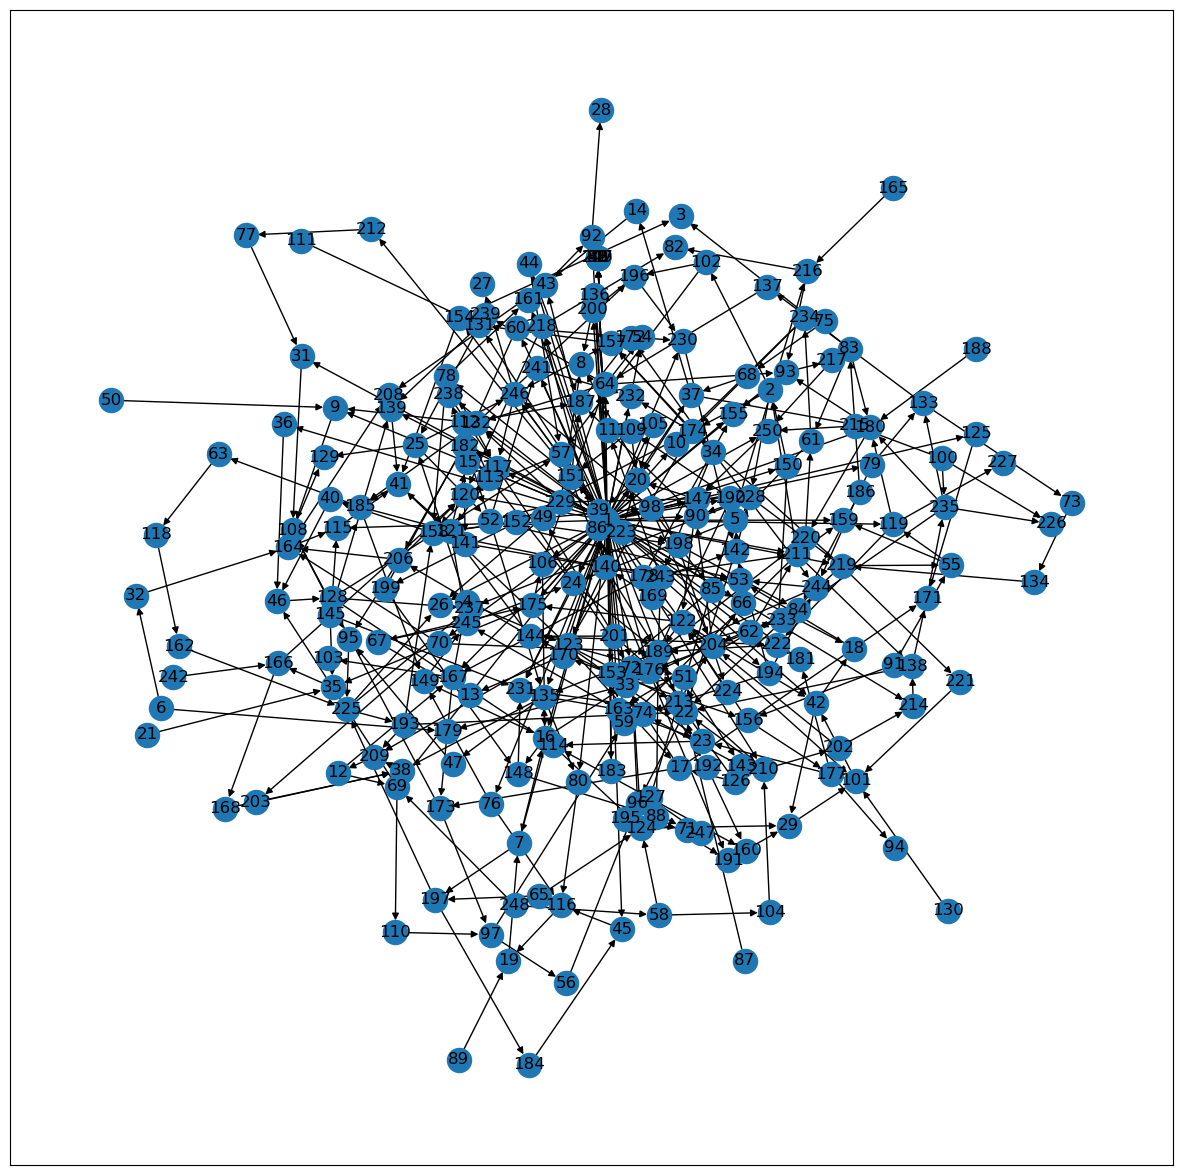

In [5]:
#рисунок один общий вид за счет камада каваи
func_for_pos = nx.kamada_kawai_layout
nx.draw_networkx(graph, pos = func_for_pos(graph), ax=plt.subplots(figsize=(15,15))[1])

plt.savefig('network_plot.png')
c.drawImage('network_plot.png', beg_str-beg_str, 50, 600, 500)
c.setFont("DejaVuSerif", 14)
c.drawString(beg_str, 620, "Граф с использованием аналитической раскладки:")
c.drawString(beg_str, 600, f"{str(func_for_pos).split(' ')[1]}")

c.setFont("DejaVuSerif", 12)
c.drawString(beg_str, 560, "Алгоритм Камада-Каваи перемещает вершины в новые положения по одной,")
c.drawString(beg_str, 540, "так что общая энергия системы уменьшается с новой конфигурацией.")
c.drawString(beg_str, 520, "Расстояние между вершинами пропорционально длине кратчайшего пути.")

cent_node = 1
c.drawString(beg_str, 70, f"Наиболее центральная вершина: {cent_node}")
os.remove('network_plot.png')

In [6]:
#новая страница
c.showPage()
c.setFont("DejaVuSerif", 14)
c.drawString(beg_str, 750, 'Метрики графа:')
c.setFont("DejaVuSerif", 12)

In [7]:
# Create a table object with the data
table = Table([df_degrees.columns.tolist()] + df_degrees.iloc[:7].values.tolist())
table.wrapOn(c, 100, 70)
table.drawOn(c, beg_str, 570)

table = Table([df_betwenness.columns.tolist()] + df_betwenness.iloc[:7].values.tolist())
table.wrapOn(c, 100, 70)
table.drawOn(c, beg_str+130, 570)

table = Table([df_pagerank.columns.tolist()] + df_pagerank.iloc[:7].values.tolist())
table.wrapOn(c, 100, 70)
table.drawOn(c, beg_str+300, 570)

c.drawString(beg_str, 720, 'Cтепени вершин')
c.drawString(beg_str+130, 720, 'Степень посредничества')
c.drawString(beg_str+300, 720, 'Pagerank (важность)')

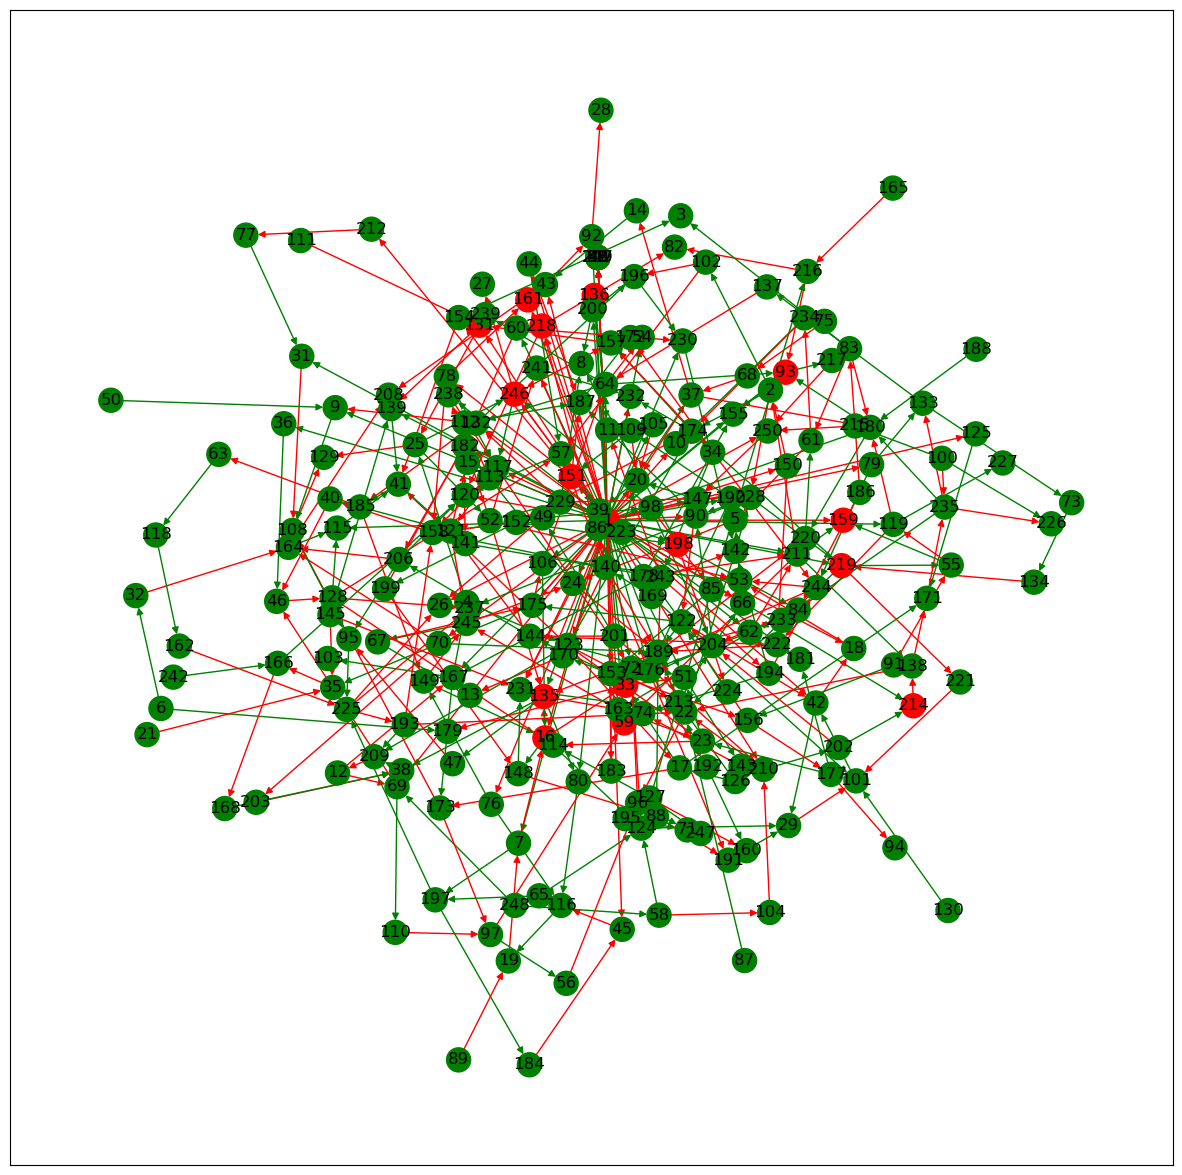

In [8]:
#рисунок 2 общий вид с подкрашенными вершинами + сюда же воткнуть топ дегрее
nx.draw_networkx(graph, pos = nx.kamada_kawai_layout(graph),
                 edge_color=list(df.color_edge),
                 node_color=color_node,
                 ax=plt.subplots(figsize=(15,15))[1])
plt.savefig('network_plot2.png')

c.drawImage('network_plot2.png', 0, 100, 600, 500)
c.drawString(beg_str, 550, "Граф, где красные вершины - степень>6, ребра - с флагом 1)")
os.remove('network_plot2.png')

In [9]:
c.drawString(beg_str, 100, f"Количество связанных компонент в графе - {len([i for i in nx.connected_components(graph_bad_all.to_undirected())])}")

In [10]:
#новая страница
c.showPage()
c.setFont("DejaVuSerif", 12)

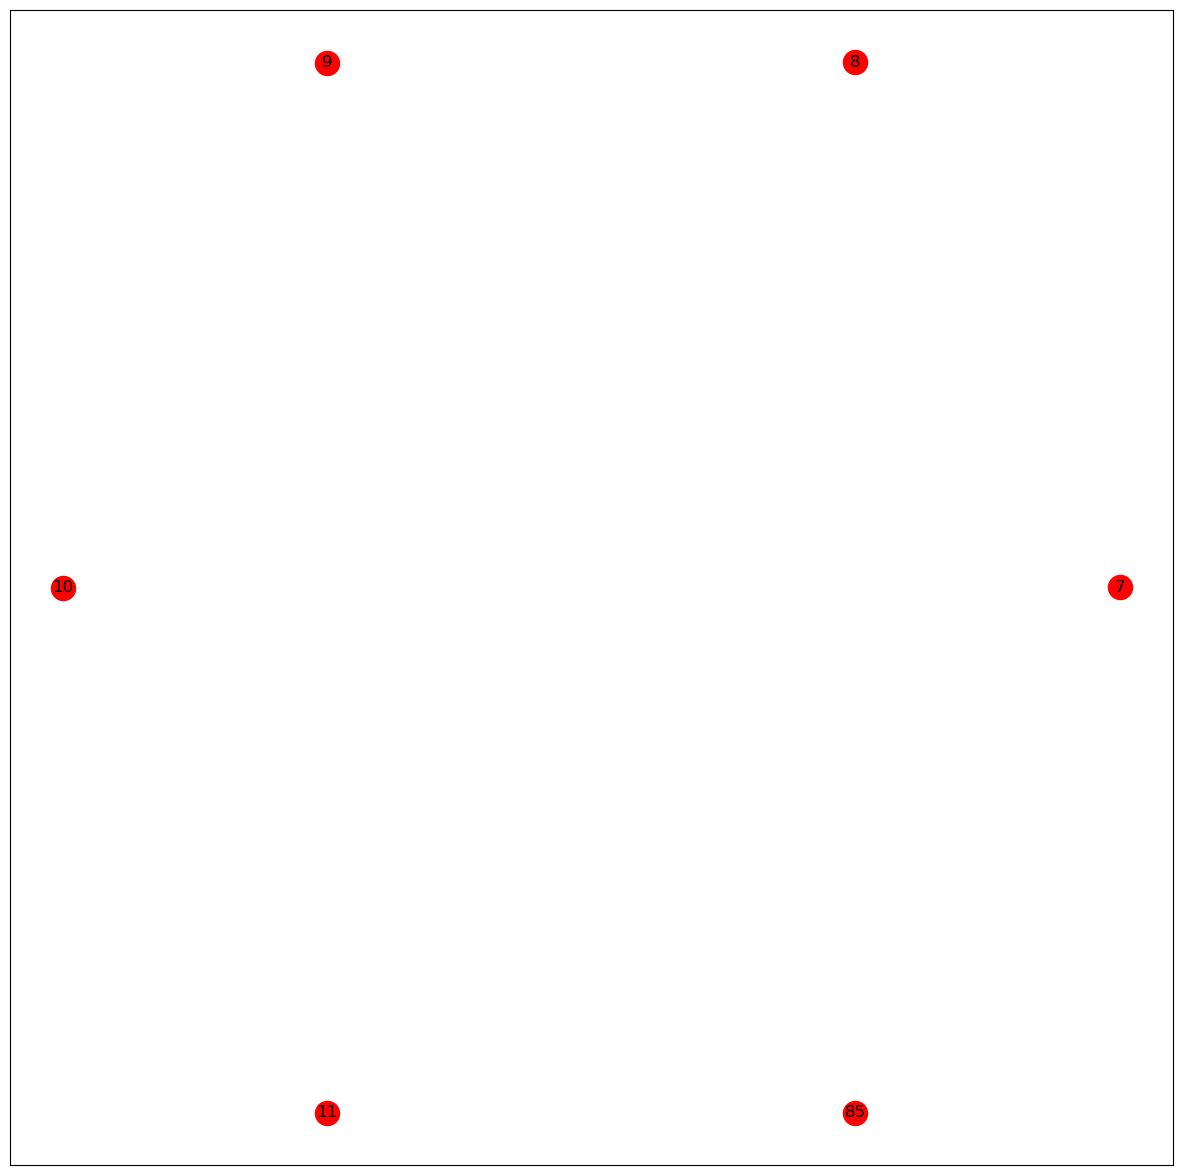

In [11]:
#рисунок один общий вид за счет камада каваи 
nx.draw_networkx(graph_bad, pos = nx.kamada_kawai_layout(graph_bad), ax=plt.subplots(figsize=(15,15))[1], node_color='red')
plt.savefig('network_plot3.png')
c.drawImage('network_plot3.png', 50, 500, 250, 250)
c.drawString(beg_str, 750, "Граф, из красных вершин")
os.remove('network_plot3.png')

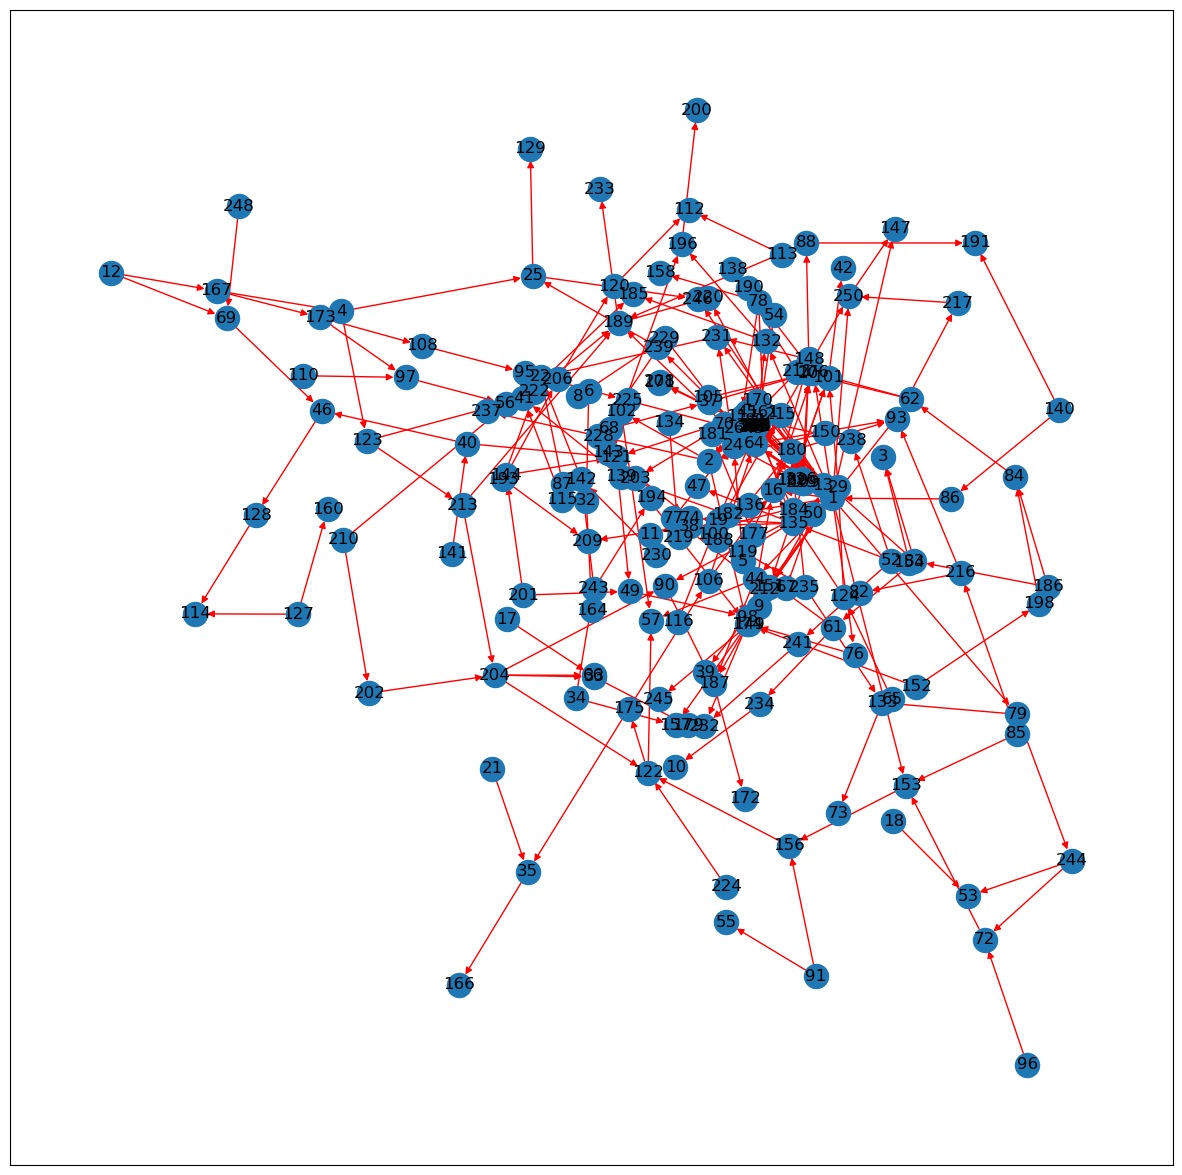

In [12]:
#рисунок один общий вид за счет камада каваи - (объяснение камада каваи)
nx.draw_networkx(graph_bad_edge, pos = nx.kamada_kawai_layout(graph_bad_edge), ax=plt.subplots(figsize=(15,15))[1], edge_color='red')
plt.savefig('network_plot4.png')
c.drawImage('network_plot4.png', 50+250, 500, 250, 250)
c.drawString(beg_str+250, 750, "Граф из красных ребер")
os.remove('network_plot4.png')

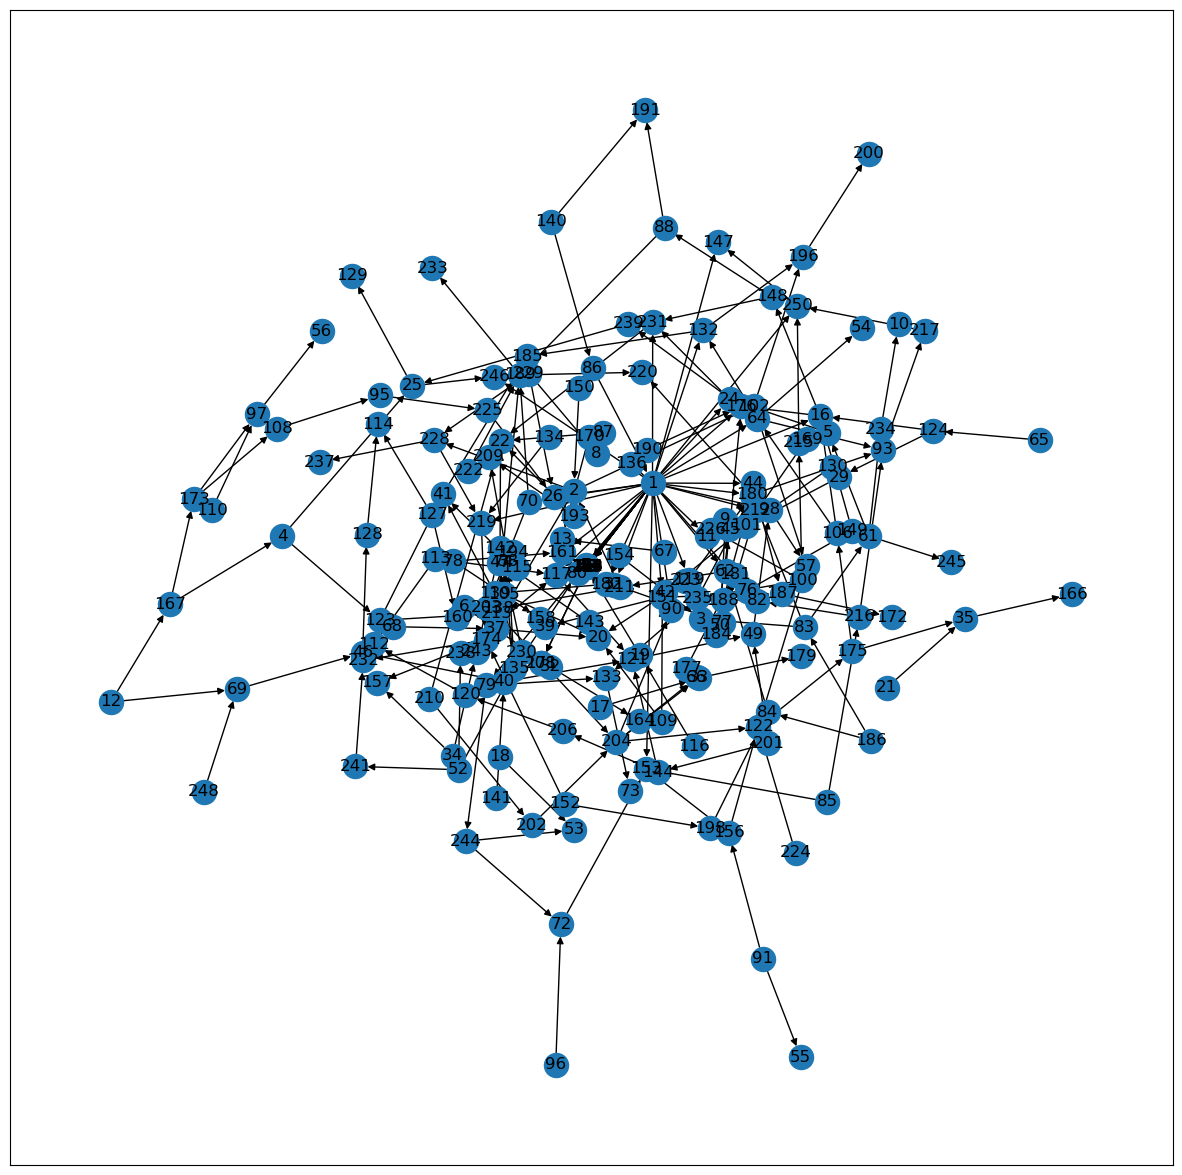

In [13]:
#рисунок один общий вид за счет камада каваи - (объяснение камада каваи)
nx.draw_networkx(graph_bad_all, pos = nx.kamada_kawai_layout(graph_bad_all),  ax=plt.subplots(figsize=(15,15))[1])
plt.savefig('network_plot5.png')
c.drawImage('network_plot5.png', 0, 0, 600, 500)
c.drawString(beg_str, 470, "Итоговый граф, c отобранными красными вершинами и ребрами")
os.remove('network_plot5.png')

In [7]:
#сохранение отчета
c.save()